From 
- notebooks/precompute_transforms.ipynb
- notebooks/timing_tests.ipynb
- tests/test_transform.py
- s2fft/transform.py

In [1]:
## Imports
import numpy as np

import pyssht as ssht 
import s2fft as s2f

import jax
from jax import jit, device_put
import jax.numpy as jnp
from jax.config import config

import matplotlib.pyplot as plt

config.update("jax_enable_x64", True)

# from s2fft.precompute.construct_legendre_matrix import load_legendre_matrix
# from s2fft.precompute.transforms import *
# from s2fft.utils import *

In [2]:
## Sample data
# alternative: earth?

# input params
L = 128 # in tests: 5
spin = 2 # in tests: [0, 1, 2]
sampling = 'dh' # in tests: ["mw", "mwss", "dh"]

# generate spherical harmonics (ground truth)
# random---modify to use JAX random key approach?
flm_gt = s2f.utils.generate_flm(L, spin, reality=False) # flm_2d = flm_1d_to_2d(flm, L) # groundtruth sph harmonics?

# compute signal in time domain (starting point)
f = ssht.inverse(s2f.samples.flm_2d_to_1d(flm_gt, L), # 2D indexed coeffs to 1D indexed
                 L,
                 Method=sampling.upper(),
                 Spin=spin,
                 Reality=False) # use ssht to compute signal in time domain-- starting point

# print(f"flm GT = {flm_gt}") # 2D complex128 np array of shape: (128, 255) (= (L, 2L-1)) 
# print(f"f = {f}") # shape: (256, 255)


In [ ]:
### Inspect flm
print(flm_gt.shape)
print(type(flm_gt))
print(flm_gt.dtype)

print(flm_gt.real.max())
print(flm_gt.real.min())

print(flm_gt.imag.max())
print(flm_gt.imag.min())
# print(flm.diagonal())

plt.matshow(flm_gt.real)
plt.colorbar()
plt.title('flm real part')
plt.matshow(flm_gt.imag)
plt.colorbar()
plt.title('flm imag part')

In [ ]:
### Inspect f
print(f.shape) #(2L, 2L-1)?

print(type(f))
print(f.dtype)

print(f.real.max())
print(f.real.min())

print(f.imag.max())
print(f.imag.min())
# print(flm.diagonal())

plt.matshow(f.real) #plt.matshow(np.abs(f.real))
plt.colorbar()
plt.title('f real part')
plt.matshow(f.imag)
plt.colorbar()
plt.title('f imag part')

(16384,)
(128, 255)
(128, 255)
True
18.1 ms ± 254 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


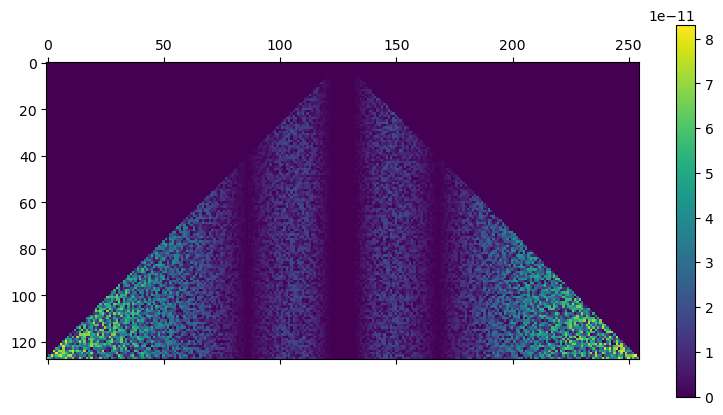

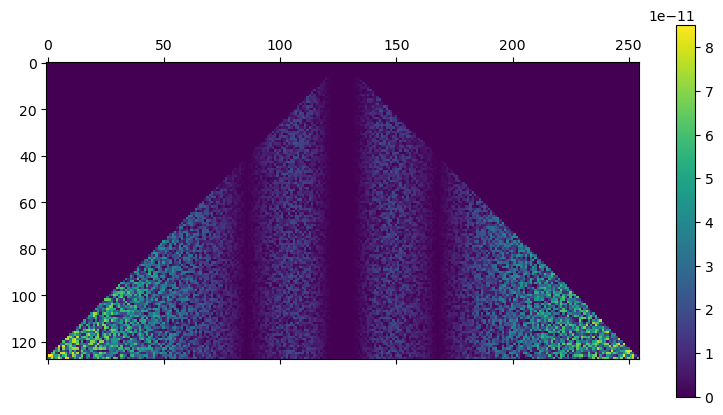

In [26]:
# Compare result from ssht toolbox (CPython) to GT
flm_ssht = ssht.forward(f, 
                        L, 
                        Spin=spin, 
                        Method=sampling, # OJO default sampling is MW
                        Reality=False) 
print(flm_ssht.shape)
print(s2f.samples.flm_1d_to_2d(flm_ssht,L).shape)
print(flm_gt.shape)

# OJO allclose is True if: absolute(a - b) <= (atol + rtol * absolute(b))
print(np.allclose(flm_gt,
                  s2f.samples.flm_1d_to_2d(flm_ssht,L),
                  atol=1e-14))

# plot diffs in real part
plt.matshow(abs(flm_gt.real - s2f.samples.flm_1d_to_2d(flm_ssht,L).real))
plt.colorbar()         
# plt.matshow(1e-14 + 1e-05*abs(s2f.samples.flm_1d_to_2d(flm_ssht,L).real)) # this should be larger than the abs diff
# plt.colorbar()  

plt.matshow(abs(flm_gt.imag - s2f.samples.flm_1d_to_2d(flm_ssht,L).imag))
plt.colorbar()    

# Timeit
%timeit flm_ssht = ssht.forward(f, L, Spin=spin, Method=sampling, Reality=False)

In [30]:
### Using direct with SOV + FFT Vectorised (*closest to jax)
flm_sov_fft_vec = s2f.transform.forward_sov_fft_vectorized(f, L, spin, sampling)

print(np.allclose(flm_gt,
                  flm_sov_fft_vec,
                  atol=1e-14))

%timeit s2f.transform.forward_sov_fft_vectorized(f, L, spin, sampling)

True
19.1 s ± 172 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3]:
jax.devices()[0]

CpuDevice(id=0)

In [ ]:
### Using JAXified version
# assumes input f is an numpy array?

flm_sov_fft_vec_jax = s2f.transform.forward_sov_fft_vectorized_jax(f, L, spin, sampling, jax.devices()[0])

# print(np.allclose(flm_gt,
#                   flm_sov_fft_vec_jax,
#                   atol=1e-14))

# %timeit s2f.transform.forward_sov_fft_vectorized_jax(f, L, spin, sampling)

In [ ]:
### Using direct (naive implementation)
flm_d = s2f.transform.forward_direct(f, L, spin, sampling)

print(np.allclose(flm_gt,
                  flm_d,
                  atol=1e-14))

# %timeit s2f.transform.forward_direct(f, L, spin, sampling)                  

In [ ]:
### Using direct with SOV 
flm_sov = s2f.transform.forward_direct_sov(f, L, spin, sampling)

print(np.allclose(flm_gt,
                  flm_sov,
                  atol=1e-14))

%timeit s2f.transform.forward_direct_sov(f, L, spin, sampling)

In [ ]:
### Using direct with SOV + FFT
flm_sov_fft = s2f.transform.forward_direct_sov_fft(f, L, spin, sampling)

print(np.allclose(flm_gt,
                  flm_sov_fft,
                  atol=1e-14))

%timeit s2f.transform.flm_sov_fft(f, L, spin, sampling)

In [ ]:
## Compare implementations (ensure same results)
# ssht CPU CPython
# %timeit 
flm_ssht = ssht.forward(f, L, spin) 

# forward direct (naive implementation)
flm_d = s2f.transform.forward_direct(f, L, spin, sampling)
# np.testing.assert_allclose(flm, flm_direct, atol=1e-14) # flm_2d?

# forward direct sov
flm_sov = s2f.transform.forward_direct_sov(f, L, spin, sampling)

# forward sov fft 
flm_sov_fft = s2f.transform.forward_direct_sov_fft(f, L, spin, sampling)

# forward sov fft vectorized
flm_sov_fft_vec = s2f.transform.forward_sov_fft_vectorized(f, L, spin, sampling)

# jax cpu (gpu if available?)
flm_jax = s2f.transform.forward_sov_fft_vectorized(f, L, spin, sampling)
# %timeit forward_transform_cpu(f, legendre_forward, L)

# jax gpu?



In [ ]:
## Compare implementations (ensure same results)
# ssht CPU CPython
%timeit ssht.forward(f, L, spin) 

# forward direct (naive implementation)
%timeit s2f.transform.forward_direct(f, L, spin, sampling)

# forward direct sov
%timeit s2f.transform.forward_direct_sov(f, L, spin, sampling)

# forward sov fft 
%timeit s2f.transform.forward_direct_sov_fft(f, L, spin, sampling)

# forward sov fft vectorized
%timeit s2f.transform.forward_sov_fft_vectorized(f, L, spin, sampling)

# jax cpu
%timeit s2f.transform.forward_sov_fft_vectorized(f, L, spin, sampling)
# %timeit forward_transform_cpu(f, legendre_forward, L)

# jax gpu?

